# Stage modelling from spatial features

In [2]:
import os
import numpy as np
import anndata as ad
import pandas as pd
from plotnine import *

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedGroupKFold, StratifiedKFold
from sklearn.metrics import f1_score, accuracy_score
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder

from sklearn.neighbors import KNeighborsClassifier
import scanpy as sc
from joblib import Parallel, delayed
import warnings, logging

## Overall cell features

In [3]:
cell_table = pd.read_csv("../../data/cell_table_with_types_stage.csv", 
                         index_col = 0)

/tmp/ipykernel_3343105/1000358550.py:1: DtypeWarning: Columns (39,40,41,42,43,44,45,46,48,49,52,53,54,55,56,57,58,59,60,61,62,63,65,66,68) have mixed types. Specify dtype option on import or set low_memory=False.


In [4]:
metab_markers = ['CA9', 'CD98', 'CytC', 'MCT1', 'ASCT2', 'LDH', 'GS', 'GLS', 'ATP5A', 'CS', 'PKM2', 'GLUT1', 'ARG1', 'CPT1A', 'Ki67']

# Only metabolic markers for cancer/epithelial cells
df = cell_table.loc[cell_table.consensus == "Cancer_cell",metab_markers] 
meta = cell_table.loc[cell_table.consensus == "Cancer_cell",["Stage","fov"]]

# A few FOVs show only few epithelial cells and might only add noise to the analysis
sparse_epi_fovs = meta.fov.value_counts()[meta.fov.value_counts() <= 20].index
df = df.loc[~meta.fov.isin(sparse_epi_fovs)]
meta = meta.loc[~meta.fov.isin(sparse_epi_fovs)]

# Only keep well-annotated stages
epithelial_subset = meta["Stage"].isin(["Colon-no.", "pT1", "pT2", "pT3", "pT4"]).values

We choose to perform the prediction task on well annotated FOVs with sufficient epithelial cells.
```python
# Note: 13 FOVs are not annotated as healthy or to a specific cancer stage
cell_table.loc[cell_table.fov.isin(meta.loc[~epithelial_subset].fov), "fov"].unique()

# Additionally, 7 FOVs do not contain epithelial cells and are therefore lost
set(cell_table.fov) - set(meta.fov)

# Finally, we also exclude 27 FOVs that contain only few epithelial cells
# The rationale is to compare on the cellular organization around the colorectal epithelium
set(sparse_epi_fovs)
```

In [5]:
# The least represented conditions are mostly unaffected
print(cell_table.groupby("fov").first().Stage.value_counts())
print(meta.loc[epithelial_subset].groupby("fov").first().Stage.value_counts())

Stage
pT3          234
pT4          105
pT2           92
pT1           19
SCT            6
Colon-no.      5
Name: count, dtype: int64
Stage
pT3          218
pT4           97
pT2           85
pT1           18
Colon-no.      5
Name: count, dtype: int64


## Prepare cross-validation

In [6]:
# Define which fovs will be held out for validation (outer loop)
fov_stage_table = meta.loc[epithelial_subset].drop_duplicates().reset_index(drop=True)
fov_inner, fov_val, y_inner, y_val = train_test_split(
    fov_stage_table["fov"], fov_stage_table["Stage"], test_size=0.2, random_state=0, stratify=fov_stage_table["Stage"])
meta["inner"] = meta["fov"].isin(fov_inner)
# For sanity check, the following should consistently be used as validation set
" ".join(fov_val.sort_values())

'A1a A1h A2g A2i A2q A2r A3m A4e A4n A5a A5f A5q A6b A6c A6g A6m A6p A6q A6r A7f A7p A8a A8h A8m A9o B1h B1k B2a B2b B2h B2k B2o B3c B3g B4b B4g B4m B5r B6i B6q B7c B7p B7r B8b B8d B8g B8i B8l B9c B9d B9h B9m B9n B9o C1l C2a C2f C2k C3c C3h C4a C4g C4k C5a C5k C5l C6d C8a C8h D1i D1l D1m D4c D4h D5b D5h D5k D5l D6b D6c D6k D7a D8d D8h E4e'

In [7]:
n_splits = 4

cv_folds = StratifiedGroupKFold(n_splits=n_splits)
for train, test in cv_folds.split(df.loc[epithelial_subset].loc[meta.loc[epithelial_subset]["inner"]],
                                  meta.loc[epithelial_subset].loc[meta["inner"]]["Stage"],
                                  groups=meta.loc[epithelial_subset].loc[meta["inner"]]["fov"]):
    # All stages should be present in both train and test
    assert len(meta.loc[epithelial_subset].loc[meta["inner"]].iloc[test].groupby("fov")["Stage"].first().unique()) == 5
    assert len(meta.loc[epithelial_subset].loc[meta["inner"]].iloc[train].groupby("fov")["Stage"].first().unique()) == 5
    # Print the first test FOVs
    print(meta.loc[epithelial_subset].loc[meta["inner"]].iloc[test].groupby("fov").first().index[:5]) 

Index(['A1d', 'A1e', 'A1l', 'A1n', 'A2e'], dtype='object', name='fov')
Index(['A1c', 'A1m', 'A1o', 'A1p', 'A1q'], dtype='object', name='fov')
Index(['A1i', 'A1r', 'A2b', 'A2c', 'A2l'], dtype='object', name='fov')
Index(['A1f', 'A1k', 'A2a', 'A2d', 'A2m'], dtype='object', name='fov')


We can split the data at the cell level to allow applications that involve processing single cells. The grouping ensures that the data is split per FOV without contamination (i.e. cells from a given FOV present both in training and testing).

In [8]:
df_per_fov = df.copy()
df_per_fov["fov"] = meta["fov"] 
df_per_fov = df_per_fov.loc[epithelial_subset].groupby("fov").mean()
meta_per_fov = meta.loc[epithelial_subset].groupby("fov").first()

Alternatively, we directly split the FOVs, for applications that involve FOV-level features. 
Note: we could generate independent folds, but the FOV distribution would not be identical.
We choose to directly define the folds to be the same to make results more comparable.
```Python
cv_folds_fov = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=2020)
for train, test in cv_folds_fov.split(df_per_fov.loc[meta_per_fov["inner"]],
                                      meta_per_fov.loc[meta_per_fov["inner"]]["Stage"]
                                    ):
    # All stages should be present in both train and test
    assert len(meta_per_fov.loc[meta_per_fov["inner"]].iloc[test]["Stage"].unique()) == 5
    assert len(meta_per_fov.loc[meta_per_fov["inner"]].iloc[train]["Stage"].unique()) == 5
    # Print the first test FOVs
    print(meta_per_fov.loc[meta_per_fov["inner"]].iloc[test].index[:5]) 

```

In [9]:
def conv_traintest_cells_to_fov():
    for train, test in cv_folds.split(df.loc[epithelial_subset].loc[meta.loc[epithelial_subset]["inner"]],
                                    meta.loc[epithelial_subset].loc[meta["inner"]]["Stage"],
                                    groups=meta.loc[epithelial_subset].loc[meta["inner"]]["fov"]):
        test_fovs = meta.loc[epithelial_subset].loc[meta["inner"]].iloc[test].groupby("fov").first().index
        train_fovs = meta.loc[epithelial_subset].loc[meta["inner"]].iloc[train].groupby("fov").first().index
        test_fovs_ind = np.where(meta_per_fov.loc[meta_per_fov["inner"]].index.isin(test_fovs))[0]
        train_fovs_ind = np.where(meta_per_fov.loc[meta_per_fov["inner"]].index.isin(train_fovs))[0]
        yield (train_fovs_ind, test_fovs_ind)

# Should work as the output of `split` method: two arrays of indices
cv_folds_fov = [x for x in conv_traintest_cells_to_fov()]

for train, test in cv_folds_fov:
    # All stages should be present in both train and test
    assert len(meta_per_fov.loc[meta_per_fov["inner"]].iloc[test]["Stage"].unique()) == 5
    assert len(meta_per_fov.loc[meta_per_fov["inner"]].iloc[train]["Stage"].unique()) == 5
    # Print the first test FOVs
    print(meta_per_fov.loc[meta_per_fov["inner"]].iloc[test].index[:5])

Index(['A1d', 'A1e', 'A1l', 'A1n', 'A2e'], dtype='object', name='fov')
Index(['A1c', 'A1m', 'A1o', 'A1p', 'A1q'], dtype='object', name='fov')
Index(['A1i', 'A1r', 'A2b', 'A2c', 'A2l'], dtype='object', name='fov')
Index(['A1f', 'A1k', 'A2a', 'A2d', 'A2m'], dtype='object', name='fov')


## Model 0: Baseline (most abundant label)

In [10]:
np.mean([f1_score(LabelEncoder().fit_transform(meta_per_fov.loc[meta_per_fov["inner"]].iloc[test]["Stage"]),
                [3 for _ in range(meta_per_fov.loc[meta_per_fov["inner"]].iloc[test].shape[0])],
                average="macro")
                for train, test in cv_folds_fov])

0.13593358969663677

## Model 1: Cell type composition

In [11]:
cell_type_proportions = cell_table.groupby("fov")["consensus"].value_counts().unstack().fillna(0)
# Normalize by the number of cells in each FOV
cell_type_proportions = cell_type_proportions.div(cell_type_proportions.sum(axis=1), axis=0)
# Match to metadata and kept FOVs
cell_type_proportions = cell_type_proportions.loc[meta_per_fov.index]

In [12]:
cross_val_score(
    XGBClassifier(
        n_estimators=250, 
        max_depth=3, 
        device="cuda", 
        random_state=0),
    cell_type_proportions.loc[meta_per_fov["inner"]],
    LabelEncoder().fit_transform(meta_per_fov.loc[meta_per_fov["inner"]]["Stage"]),
    cv=cv_folds_fov, 
    scoring='f1_macro')

/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [14:18:44] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.



array([0.21614339, 0.24350877, 0.19701984, 0.22308611])

For cell type composition, XGBoost seems appropriate.
```Python
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

# Define models and their hyperparameters
models = {
    'RandomForest': RandomForestClassifier(),
    'XGBoost': XGBClassifier(),
    'SVM': SVC(),
    'LogisticRegression': LogisticRegression()
}

params = {
    'RandomForest': {
        'n_estimators': [50, 100, 200, 300],
        'max_depth': [3, 5, 7]
    },
    'XGBoost': {
        'n_estimators': [50, 100, 200, 300],
        'max_depth': [3, 5],
        'device': ['cuda'],
        'random_state': [0]
    },
    'SVM': {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf']
    },
    'LogisticRegression': {
        'C': [0.1, 1, 10],
        'solver': ['lbfgs']
    }
}

# Perform GridSearchCV for each model
best_models = {}
best_scores = {}
for model_name in models:
    grid_search = GridSearchCV(models[model_name], params[model_name], cv=cv_folds_fov, scoring='f1_macro')
    grid_search.fit(cell_type_proportions.loc[meta_per_fov["inner"]], LabelEncoder().fit_transform(meta_per_fov.loc[meta_per_fov["inner"]]["Stage"]))
    best_models[model_name] = grid_search.best_estimator_
    best_scores[model_name] = grid_search.best_score_

# Print the best models and their parameters
for model in best_models.keys():
    print(model, best_models[model])
    print("Best score:", best_scores[model])

```

RandomForest RandomForestClassifier(max_depth=7, n_estimators=50)
Best score: 0.18921113795228467
XGBoost XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='cuda', early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=50, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)
Best score: 0.22902662111995187
SVM SVC(C=10)
Best score: 0.16942377871729714
LogisticRegression LogisticRegression(C=10)
Best sco

In [13]:
def process_fold_composition(train, test, n_estimators = 250):
    logging.getLogger('tensorflow').setLevel(logging.ERROR)
    with warnings.catch_warnings(action="ignore"):      
        # Step 1: Define train and test subsets of the compositional data
        train_composition = cell_type_proportions.loc[meta_per_fov["inner"]].iloc[train]
        test_composition = cell_type_proportions.loc[meta_per_fov["inner"]].iloc[test]
        train_meta = meta_per_fov.loc[meta_per_fov["inner"]].iloc[train]["Stage"]
        test_meta = meta_per_fov.loc[meta_per_fov["inner"]].iloc[test]["Stage"]

        # Step 2: Train a classifier on the training data composition to predict the stage of each FOV
        xgb = XGBClassifier(
            n_estimators=n_estimators, 
            max_depth=3, 
            device="cuda", 
            random_state=0)
        xgb.fit(train_composition,
                LabelEncoder().fit_transform(train_meta))

        # Step 3: Predict stage of each FOV in the test data
        preds = xgb.predict(test_composition)

        # Step 4: Compute f1_score
        score = f1_score(LabelEncoder().fit_transform(test_meta), 
                        preds, 
                        average="macro")
        return score

In [14]:
def test_estimator_composition(estimators):
    scores = [process_fold_composition(train, test, n_estimators=estimators)
              for train, test in cv_folds_fov]
    mean_score = np.mean(scores)
    # Append to f1 score log file
    with open(f"../../data/model1_cell_composition_f1_scores.txt", "a") as f:
        f.write(f"{estimators},{mean_score}\n")
    
    print(estimators, mean_score)
    return mean_score

In [ ]:
# Parallelize the hyperparameter loop | ~81mn
Parallel(n_jobs=28)(delayed(test_estimator_composition)(r_estimators)
                for r_estimators in np.arange(50, 1001, 10))

In [15]:
pd.read_csv("../../data/model1_cell_composition_f1_scores.txt", header=None, names=["estimators", "score"]).sort_values("score", ascending=False).head(10)

,estimators,score
11,160,0.242821
7,120,0.236187
10,150,0.235734
9,140,0.235244
8,130,0.234784
1,60,0.232371
71,760,0.230606
4,90,0.226521
0,50,0.226464
2,70,0.224813


## Model 2: Metabolic clusters
See *MetabViz.ipynb* for details.

In [16]:
cross_val_score(
    XGBClassifier(
        n_estimators=250, 
        max_depth=3, 
        device="cuda", 
        random_state=0),
    df.loc[epithelial_subset].loc[meta.loc[epithelial_subset]["inner"]],
    LabelEncoder().fit_transform(meta.loc[epithelial_subset].loc[meta["inner"]]["Stage"]),
    groups=meta.loc[epithelial_subset].loc[meta["inner"]]["fov"], 
    cv=cv_folds, 
    scoring='f1_macro')

array([0.21137964, 0.31287193, 0.25688164, 0.19952781])

In [17]:
pd.read_csv("../../data/cluster_f1_scores.txt").sort_values("score", ascending=False).head(10)

,resolution,neighbors,estimators,score
153,0.23,5,169,0.369303
68,0.90,5,440,0.360735
56,0.13,11,31,0.355948
352,0.63,3,268,0.354892
140,0.86,4,369,0.351360
47,0.29,2,228,0.350469
48,0.29,2,242,0.348103
172,0.58,2,356,0.345388
315,0.35,9,165,0.342340
271,0.41,6,448,0.341682


In [18]:
res = 0.23
neighbors = 5
estimators = 169

In [19]:
def process_fold(train, test, n_neighbors = 30, resolution = 0.5, n_estimators = 250):
    logging.getLogger('tensorflow').setLevel(logging.ERROR)
    with warnings.catch_warnings(action="ignore"):
        # Step 1: Define metabolic clusters on training data
        ad = sc.AnnData(df.loc[epithelial_subset].loc[meta.loc[epithelial_subset]["inner"]].iloc[train])
        sc.pp.neighbors(ad, n_neighbors=n_neighbors)
        sc.tl.leiden(ad, resolution=resolution)
        ad.obs.leiden = ad.obs.leiden.values.astype(int)

        # Step 2: Define a classifier to propagate the clusters to the test data
        neigh = KNeighborsClassifier(n_neighbors=n_neighbors, n_jobs=-1)
        neigh.fit(df.loc[epithelial_subset].loc[meta.loc[epithelial_subset]["inner"]].iloc[train].values, 
                ad.obs.leiden.values)

        # Step 3: Compute proportion of cells in each cluster for each FOV in the training data
        train_fov_cluster_composition = pd.DataFrame(ad.obs.leiden.values, columns=["Cluster"])
        train_fov_cluster_composition["fov"] = (
            meta.loc[epithelial_subset].loc[meta.loc[epithelial_subset]["inner"]].iloc[train]["fov"].values
        )
        train_fov_cluster_composition = (
            train_fov_cluster_composition.groupby("fov")["Cluster"].value_counts().unstack().fillna(0)
        )
        # Normalize by the number of cells in each FOV
        train_fov_cluster_composition = (
            train_fov_cluster_composition.div(train_fov_cluster_composition.sum(axis=1), axis=0)
        )

        # Step 4: Train a classifier on the training data composition to predict the stage of each FOV
        xgb = XGBClassifier(
            n_estimators=n_estimators, 
            max_depth=3, 
            device="cuda", 
            random_state=0)
        xgb.fit(train_fov_cluster_composition,
                LabelEncoder().fit_transform(meta.loc[epithelial_subset].loc[meta["inner"]].groupby("fov").first()["Stage"].loc[train_fov_cluster_composition.index]))
        
        # Step 5: Predict clusters on test data
        test_clusters = neigh.predict(df.loc[epithelial_subset].loc[meta.loc[epithelial_subset]["inner"]].iloc[test].values)

        # Step 6: Compute proportion of cells in each cluster for each FOV in the test data
        test_fov_cluster_composition = pd.DataFrame(test_clusters, columns=["Cluster"])
        test_fov_cluster_composition["fov"] = meta.loc[epithelial_subset].loc[meta.loc[epithelial_subset]["inner"]].iloc[test]["fov"].values
        test_fov_cluster_composition = test_fov_cluster_composition.groupby("fov")["Cluster"].value_counts().unstack().fillna(0)
        # Normalize by the number of cells in each FOV
        test_fov_cluster_composition = test_fov_cluster_composition.div(test_fov_cluster_composition.sum(axis=1), axis=0)
        
        # Ensure all clusters are covered in the testing dataframe
        for cluster in train_fov_cluster_composition.columns:
            if cluster not in test_fov_cluster_composition.columns:
                test_fov_cluster_composition[cluster] = 0

        # Reorder columns to match the training set
        test_fov_cluster_composition = test_fov_cluster_composition[train_fov_cluster_composition.columns]

        # Step 7: Predict stage of each FOV in the test data
        preds = xgb.predict(test_fov_cluster_composition)

        # Step 8: Compute f1_score
        score = f1_score(LabelEncoder().fit_transform(meta.loc[epithelial_subset].loc[meta["inner"]].groupby("fov").first()["Stage"].loc[test_fov_cluster_composition.index]), 
                        preds, 
                        average="macro")
        return score
    
# Function to process a single set of hyperparameters
def process_hyperparameters(r_resolution, r_neighbors, r_estimators):
    r_neighbors = int(r_neighbors)
    print(r_resolution, r_neighbors, r_estimators)
    scores = Parallel(n_jobs=1)(delayed(process_fold)(train, 
                                                       test, 
                                                       n_neighbors=r_neighbors,
                                                       resolution=r_resolution,
                                                       n_estimators=r_estimators) 
                                 for train, test in cv_folds.split(
        df.loc[epithelial_subset].loc[meta.loc[epithelial_subset]["inner"]],
        meta.loc[epithelial_subset].loc[meta["inner"]]["Stage"],
        groups=meta.loc[epithelial_subset].loc[meta["inner"]]["fov"]
    ))
    mean_score = np.mean(scores)
    print("[Results]  ", r_resolution, r_neighbors, r_estimators, mean_score)
    
    # Ensure file exists
    if not os.path.isfile("../../data/cluster_f1_scores.txt"):
        with open("../../data/cluster_f1_scores.txt", "w") as f:
            f.write("resolution,neighbors,estimators,score\n")

    # Append to f1 score log file
    with open(f"../../data/cluster_f1_scores.txt", "a") as f:
        f.write(f"{r_resolution},{r_neighbors},{r_estimators},{mean_score}\n")

In [19]:
scores = Parallel(n_jobs=-1)(delayed(process_fold)(train, 
                                                    test, 
                                                    n_neighbors=neighbors,
                                                    resolution=res,
                                                    n_estimators=estimators) 
                                 for train, test in cv_folds.split(
        df.loc[epithelial_subset].loc[meta.loc[epithelial_subset]["inner"]],
        meta.loc[epithelial_subset].loc[meta["inner"]]["Stage"],
        groups=meta.loc[epithelial_subset].loc[meta["inner"]]["fov"]
    )) # This should confirm the model selection estimates

print(np.mean(scores))

2025-01-17 10:21:24.894803: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-17 10:21:24.894803: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-17 10:21:25.063990: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-17 10:21:25.063990: I tensorflow/core/platform/cpu_feature_g

0.36930323414085386


## Model 3: MISTy cell type features
See *MistyLines.ipynb*.

In [20]:
misty_features_raw = pd.read_csv("../../data/misty_lineage_features.csv", index_col=0)
# Subset to top 100 most common features
misty_features = misty_features_raw.iloc[:,np.argsort(-np.sum(misty_features_raw > 0))[:100]]

In [21]:
# Order is preserved
assert meta_per_fov.index.equals(misty_features.index)

In [22]:
def process_fold_misty(train, test, n_estimators = 250):
    logging.getLogger('tensorflow').setLevel(logging.ERROR)
    with warnings.catch_warnings(action="ignore"):
        # Step 1: Define train and test subsets of the MISTy data
        train_misty = misty_features.loc[meta_per_fov["inner"]].iloc[train]
        test_misty = misty_features.loc[meta_per_fov["inner"]].iloc[test]
        train_meta = meta_per_fov.loc[meta_per_fov["inner"]].iloc[train]["Stage"]
        test_meta = meta_per_fov.loc[meta_per_fov["inner"]].iloc[test]["Stage"]
        
        # Step 2: Train a classifier on the training data to predict the stage of each FOV
        xgb = XGBClassifier(
            n_estimators=n_estimators, 
            max_depth=3, 
            device="cuda", 
            random_state=0)
        xgb.fit(train_misty,
                LabelEncoder().fit_transform(train_meta))
        
        # # Step 3: Predict stage of each FOV in the test data
        preds = xgb.predict(test_misty)

        # # Step 4: Compute f1_score
        score = f1_score(LabelEncoder().fit_transform(test_meta), 
                        preds, 
                        average="macro")
        return score

In [23]:
def test_estimator_misty(estimators):
    scores = [process_fold_misty(train, test, n_estimators=estimators)
              for train, test in cv_folds_fov]
    mean_score = np.mean(scores)
    # Append to f1 score log file
    with open(f"../../data/model3_misty_lineage_f1_scores.txt", "a") as f:
        f.write(f"{estimators},{mean_score}\n")
    
    print(estimators, mean_score)
    return mean_score

In [85]:
# Parallelize the hyperparameter loop | ~81mn
Parallel(n_jobs=28)(delayed(test_estimator_misty)(r_estimators)
                for r_estimators in np.arange(50, 1001, 10))

50 0.2122826021299442
60 0.20790613779632489
70 0.202330259510537
80 0.20343956777033295
90 0.1983918453250522
110 0.2150436794569184
100 0.20629192851356093
120 0.21422436349828008
130 0.21999971128450896
140 0.2207570840038846
150 0.23224074143968376
160 0.23710359433343736
170 0.24036267271079695
250 0.21459959425291114
180 0.2166397014531722
190 0.22329734469950116
200 0.22410895337312595
210 0.21981982458503999
220 0.2190915180899541
230 0.2144821561007942
240 0.2127295977349569
260 0.2174538461333594
270 0.21257154287828262
280 0.2185392272518598
290 0.22325545531093008
300 0.22325545531093008
310 0.21906740090376572
320 0.22038955387568387
330 0.22333938341032208
340 0.22038955387568387
350 0.21690718808402215
360 0.21465742535840188
370 0.21914629272970004
380 0.21911469609948311
390 0.21910502517238098
400 0.21809766660793908
410 0.21907257155735857
420 0.2201196853630931
430 0.21908185981336298
440 0.21908185981336298
450 0.21907218888626084
460 0.21908185981336298
470 0.2191

[0.2122826021299442,
 0.20790613779632489,
 0.202330259510537,
 0.20343956777033295,
 0.1983918453250522,
 0.20629192851356093,
 0.2150436794569184,
 0.21422436349828008,
 0.21999971128450896,
 0.2207570840038846,
 0.23224074143968376,
 0.23710359433343736,
 0.24036267271079695,
 0.2166397014531722,
 0.22329734469950116,
 0.22410895337312595,
 0.21981982458503999,
 0.2190915180899541,
 0.2144821561007942,
 0.2127295977349569,
 0.21459959425291114,
 0.2174538461333594,
 0.21257154287828262,
 0.2185392272518598,
 0.22325545531093008,
 0.22325545531093008,
 0.21906740090376572,
 0.22038955387568387,
 0.22333938341032208,
 0.22038955387568387,
 0.21690718808402215,
 0.21465742535840188,
 0.21914629272970004,
 0.21911469609948311,
 0.21910502517238098,
 0.21809766660793908,
 0.21907257155735857,
 0.2201196853630931,
 0.21908185981336298,
 0.21908185981336298,
 0.21907218888626084,
 0.21908185981336298,
 0.21915755610524879,
 0.21915755610524879,
 0.21915755610524879,
 0.19889616700890825,
 

In [24]:
pd.read_csv("../../data/model3_misty_lineage_f1_scores.txt", header=None, names=["estimators", "score"]).sort_values("score", ascending=False).head(10)

,estimators,score
12,170,0.240363
11,160,0.237104
10,150,0.232241
16,200,0.224109
28,330,0.223339
15,190,0.223297
24,290,0.223255
25,300,0.223255
9,140,0.220757
29,340,0.220390


## Model 4: Kasumi metabolic features
See *KasumiColorectal.ipynb*.

## Model 5: Morphological features

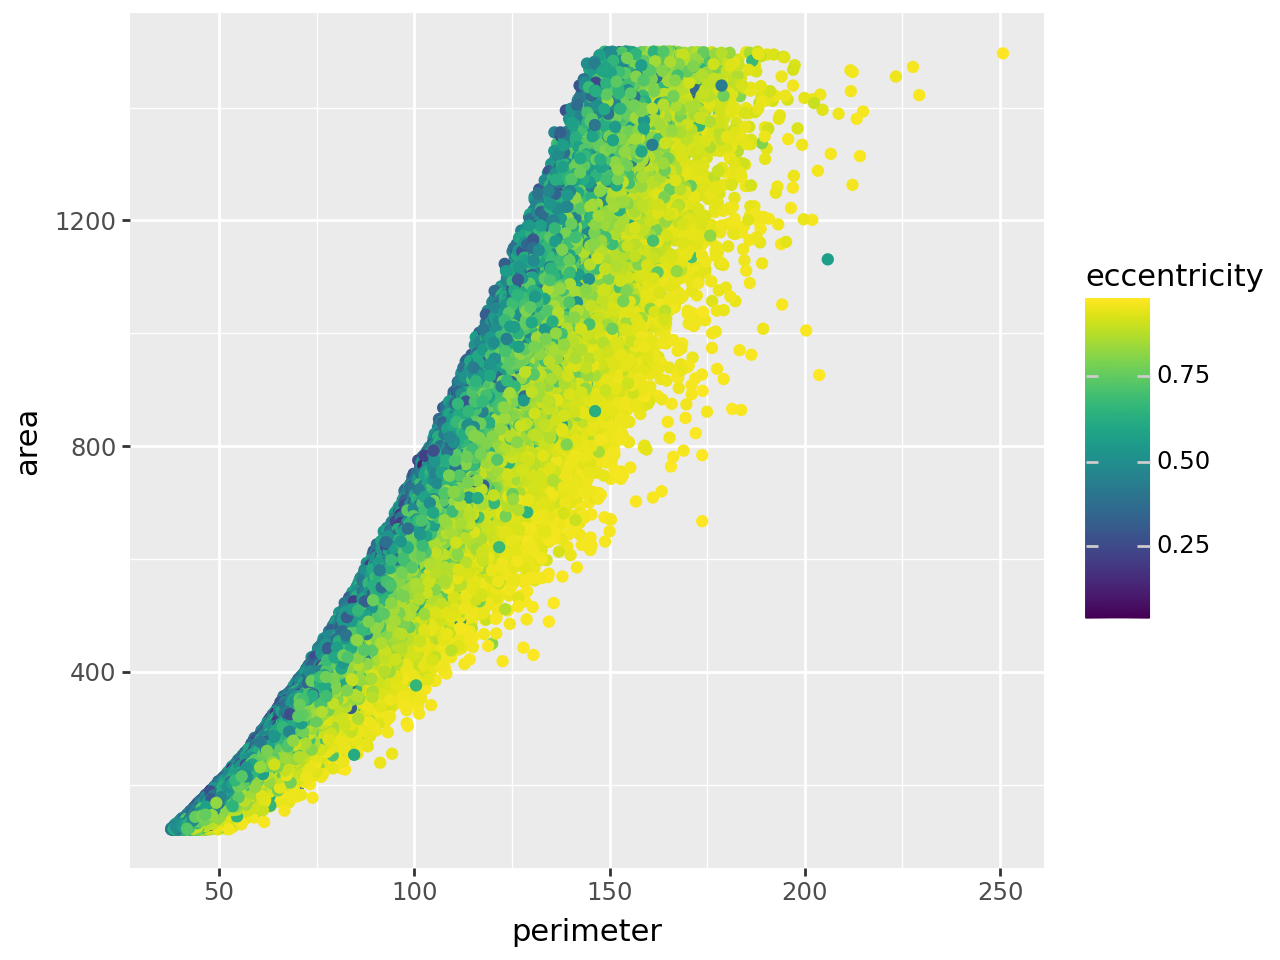

In [243]:
# Information appears correlated but complementary
ggplot(cell_table, aes(x = 'perimeter', y = 'area', color = 'eccentricity')) + geom_point()

In [323]:
morpho_features = ['eccentricity', 'perimeter', 'area']

# We start by looking at the cell shape of cancer cells
df_morpho = cell_table.loc[cell_table.consensus == "Cancer_cell",morpho_features] 
df_morpho.index = df_morpho.index.astype(str)
df_morpho = df_morpho.loc[meta.index].loc[epithelial_subset]
df_morpho["fov"] = meta.loc[epithelial_subset]["fov"]
# For mean only
# df_morpho_per_fov = df_morpho.groupby("fov").mean()
# For mean and std
df_morpho_per_fov = df_morpho.groupby("fov").mean().join(df_morpho.groupby("fov").std(), rsuffix="_std")

assert meta_per_fov.index.equals(df_morpho_per_fov.index)

In [324]:
cross_val_score(
    XGBClassifier(
        n_estimators=250, 
        max_depth=3, 
        device="cuda", 
        random_state=0),
    df_morpho_per_fov.loc[meta_per_fov["inner"]],
    LabelEncoder().fit_transform(meta_per_fov.loc[meta_per_fov["inner"]]["Stage"]),
    cv=cv_folds_fov, 
    scoring='f1_macro')

array([0.22499621, 0.21777778, 0.21183456, 0.18855914])

In [325]:
def process_fold_morphology(train, test, n_estimators = 250):
    logging.getLogger('tensorflow').setLevel(logging.ERROR)
    with warnings.catch_warnings(action="ignore"):      
        # Step 1: Define train and test subsets of the compositional data
        train_morphology = df_morpho_per_fov.loc[meta_per_fov["inner"]].iloc[train]
        test_morphology = df_morpho_per_fov.loc[meta_per_fov["inner"]].iloc[test]
        train_meta = meta_per_fov.loc[meta_per_fov["inner"]].iloc[train]["Stage"]
        test_meta = meta_per_fov.loc[meta_per_fov["inner"]].iloc[test]["Stage"]

        # Step 2: Train a classifier on the training data composition to predict the stage of each FOV
        xgb = XGBClassifier(
            n_estimators=n_estimators, 
            max_depth=3, 
            device="cuda", 
            random_state=0)
        xgb.fit(train_morphology,
                LabelEncoder().fit_transform(train_meta))

        # Step 3: Predict stage of each FOV in the test data
        preds = xgb.predict(test_morphology)

        # Step 4: Compute f1_score
        score = f1_score(LabelEncoder().fit_transform(test_meta), 
                        preds, 
                        average="macro")
        return score

In [326]:
def test_estimator_morphology(estimators):
    scores = [process_fold_morphology(train, test, n_estimators=estimators)
              for train, test in cv_folds_fov]
    mean_score = np.mean(scores)
    # Append to f1 score log file
    with open(f"../../data/model4_cell_morphology_f1_scores.txt", "a") as f:
        f.write(f"{estimators},{mean_score}\n")
    
    print(estimators, mean_score)
    return mean_score

In [327]:
# Parallelize the hyperparameter loop | ~81mn
Parallel(n_jobs=28)(delayed(test_estimator_morphology)(r_estimators)
                for r_estimators in np.arange(50, 1001, 10))

170 0.21992826839183574
450 0.2130812060559503
730 0.21420219649286645
180 0.2201152326406001
460 0.21332831551358608
740 0.21420219649286645
190 0.21734392883526044
470 0.2143717363028445
750 0.21763897195211382


[0.2220095883983416,
 0.21505226880526382,
 0.21784589539309002,
 0.22315070042533144,
 0.2252410672696148,
 0.22271181674369933,
 0.2188367495261723,
 0.2183000302006235,
 0.21919275663223114,
 0.21736812970348773,
 0.2210873478728338,
 0.2162237795387279,
 0.21992826839183574,
 0.2201152326406001,
 0.21734392883526044,
 0.21656389505962353,
 0.21373222828629562,
 0.22089189836574363,
 0.21770357364256243,
 0.21174516665887294,
 0.21079192302308303,
 0.2162083941984787,
 0.20837510091193745,
 0.21086088645126203,
 0.21051749866819658,
 0.21257670619085087,
 0.21195555281150918,
 0.2121896730747098,
 0.21629445315919327,
 0.21537494251577444,
 0.2173184945468301,
 0.21668257798228635,
 0.21539666684257935,
 0.21543752486096546,
 0.21543752486096546,
 0.2154706290117167,
 0.21553705683676522,
 0.21664947383153513,
 0.21664947383153513,
 0.2130812060559503,
 0.2130812060559503,
 0.21332831551358608,
 0.2143717363028445,
 0.21318636328888443,
 0.21318636328888443,
 0.21318636328888443,
 0

In [328]:
pd.read_csv("../../data/model4_cell_morphology_f1_scores.txt", header=None, names=["estimators", "score"]).sort_values("score", ascending=False).head(10)

,estimators,score
5,90,0.225241
4,80,0.223151
6,100,0.222712
0,50,0.222010
75,800,0.221871
10,150,0.221087
17,220,0.220892
80,850,0.220598
13,180,0.220115
12,170,0.219928


In principle, we could as well look at the morphology of other cell types in the TME. However, this would require to make a lot of choices, as the FOVs with enough cells might not be the same, leading to non-trivial comparisons.

```Python
cells_per_fov = cell_table.groupby("fov").consensus.value_counts().unstack()
# Count NAs per type
cells_per_fov.isna().sum(axis="rows")
# We can also look at the morphology of CAF, NK_cell, CD4_Tcell, Monocyte,
# Endothelial_cell, Other_immune_cell

# morpho_features = ['eccentricity', 'perimeter', 'area']

# We now look at the cell shape of fibroblast cells
df_morpho = cell_table.loc[cell_table.consensus == "CAF",morpho_features] 

# Match meta dataframe
meta_morpho = cell_table.loc[cell_table.consensus == "CAF",["Stage","fov"]]
# Filter for well-annotated stages
meta_morpho = meta_morpho.loc[meta_morpho["Stage"].isin(["Colon-no.", "pT1", "pT2", "pT3", "pT4"])]
meta_morpho = meta_morpho.loc[~meta_morpho.fov.isin(
    meta_morpho.fov.value_counts()[meta_morpho.fov.value_counts() <= 3].index
    )]

df_morpho = df_morpho.loc[meta_morpho.index]
df_morpho["fov"] = meta_morpho["fov"]
# For mean only
# df_morpho_per_fov = df_morpho.groupby("fov").mean()
# For mean and std
df_morpho_per_fov = df_morpho.groupby("fov").mean().join(df_morpho.groupby("fov").std(), rsuffix="_std")
meta_morpho_per_fov = meta_morpho.groupby("fov").first()

assert meta_morpho_per_fov.index.equals(df_morpho_per_fov.index)

# Note: if the predictions are not done on the same FOVs, comparison is not possible
# and the cross-validation splits cannot be re-used
```